# River Plastic Pollution & Ocean Currents Analysis
## Complete Analysis Pipeline

This notebook analyzes river plastic pollution through 6 key goals:
1. Identify Top Plastic-Polluting Rivers & Their Countries
2. Analyze How Ocean Currents Affect Plastic Dispersion
3. Estimate Which Countries Contribute the Most Plastic
4. Study How Weather Influences Plastic Leakage
5. Compare Plastic Risk Scenarios (2015-2060)
6. Build Plastic-Current Risk Scores for Rivers

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 1. Data Loading and Initial Exploration

In [4]:
# Load all datasets
print("Loading datasets...")

# 1. Global rivers dataset
rivers_df = pd.read_csv('../data/raw/global_rivers_dataset.csv')

# 2. Weather data (sample for demo)
weather_df = pd.read_csv('../data/raw/GlobalWeatherRepository.csv')  # FULL dataset

# 3. Mismanaged waste data
waste_df = pd.read_csv('../data/raw/mismanaged-waste-global-total.csv')

# 4. Top rivers
top_rivers_df = pd.read_csv('../data/raw/plastics-top-rivers.csv')

# 5. Risk scenarios
risk_df = pd.read_csv('../data/raw/River_Plastic_Waste_Risk_Scenarios_2015_2060.csv')

# 6. River currents summary (created from HYCOM files)
currents_df = pd.read_csv('../data/processed/river_currents_summary_2024.csv')

Loading datasets...


## 2. Data Cleaning and Preparation

In [5]:
def clean_and_prepare_data():
    """Clean and prepare all datasets for analysis using real columns."""

    top_rivers_df_clean = None
    rivers_df_clean = None
    currents_clean = None

    # ---------- Top rivers (plastics-top-rivers.csv) ----------
    if 'top_rivers_df' in globals():
        top_rivers_df_clean = top_rivers_df.copy()

        # Rename Entity -> River
        if 'Entity' in top_rivers_df_clean.columns and 'River' not in top_rivers_df_clean.columns:
            top_rivers_df_clean = top_rivers_df_clean.rename(columns={'Entity': 'River'})

        # sharePlastics is our only plastic metric → make sure it's numeric
        if 'sharePlastics' in top_rivers_df_clean.columns:
            top_rivers_df_clean['sharePlastics'] = pd.to_numeric(
                top_rivers_df_clean['sharePlastics'], errors='coerce'
            )

        # Alias sharePlastics as plastic_tons so the rest of the code works
        if 'plastic_tons' not in top_rivers_df_clean.columns and 'sharePlastics' in top_rivers_df_clean.columns:
            top_rivers_df_clean['plastic_tons'] = top_rivers_df_clean['sharePlastics']

        print(f"Top rivers data: {top_rivers_df_clean.shape[0]} rows, "
              f"{top_rivers_df_clean['River'].nunique()} unique rivers")
    else:
        print("top_rivers_df not found in globals()")

    # ---------- Global rivers ----------
    if 'rivers_df' in globals():
        rivers_df_clean = rivers_df.copy()
        print(f"Global rivers data: {rivers_df_clean.shape[0]} rivers")
    else:
        rivers_df_clean = None
        print("rivers_df not found in globals()")

    # ---------- Currents summary ----------
    if 'currents_df' in globals():
        currents_clean = currents_df.copy()
        print(f"Currents summary: {currents_clean.shape[0]} rivers")
    else:
        currents_clean = None
        print("currents_df not found in globals()")

    # ---------- Merge plastics (top_rivers) with HYCOM currents ----------
    merged_df = None
    if top_rivers_df_clean is not None and currents_clean is not None:
        if 'River' in top_rivers_df_clean.columns and 'river_name' in currents_clean.columns:
            merged_df = pd.merge(
                top_rivers_df_clean,
                currents_clean,
                left_on='River',
                right_on='river_name',
                how='left'
            )
            print(f"Merged rivers + currents: {merged_df.shape[0]} rows")
        else:
            print("Cannot merge: missing 'River' in top_rivers or 'river_name' in currents.")
    else:
        print("Merged dataset not created (missing top_rivers_df or currents_df).")

    return merged_df, rivers_df_clean


merged_rivers_df, global_rivers_clean = clean_and_prepare_data()


Top rivers data: 50 rows, 50 unique rivers
Global rivers data: 1387 rivers
Currents summary: 523 rivers
Merged rivers + currents: 50 rows


## GOAL 1: Identify Top Plastic-Polluting Rivers & Their Countries


GOAL 1: Top Plastic-Polluting Rivers & Their Countries


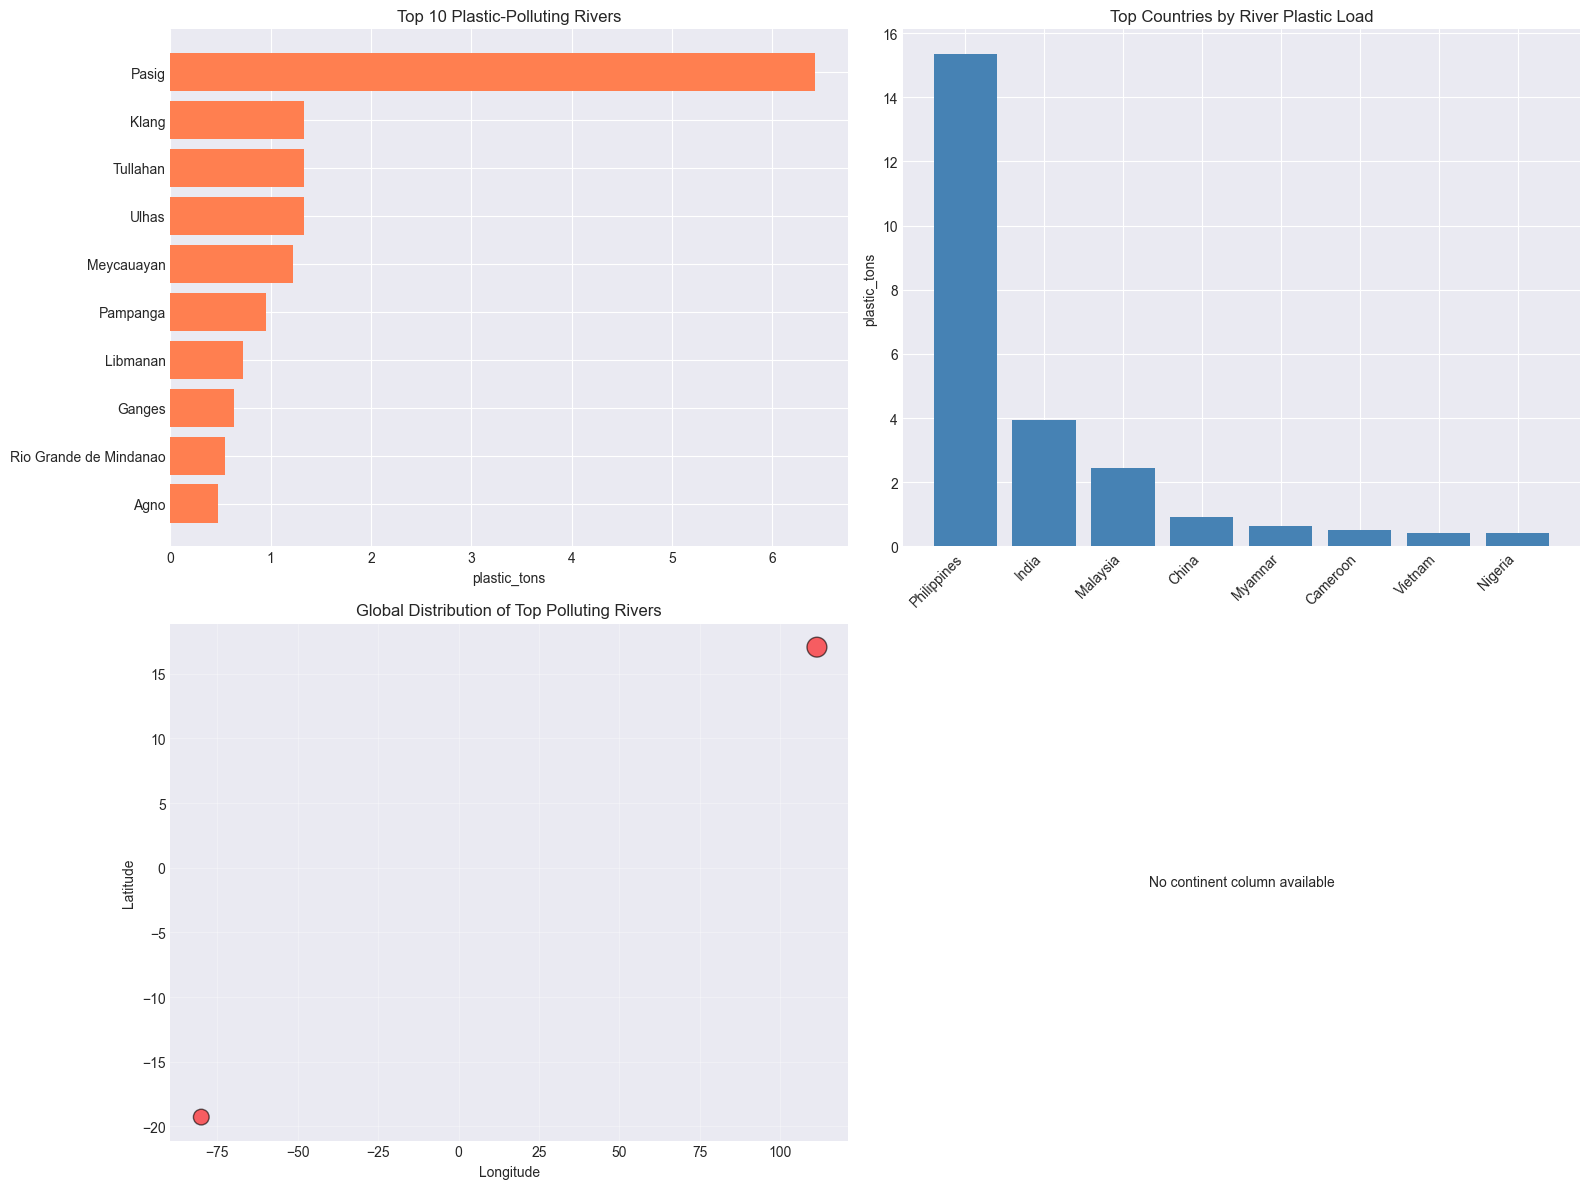


📊 Summary Statistics:
Total rivers analyzed: 50
Total plastic_tons: 26.9945
Average per river: 0.5399
Maximum: 6.4321


In [26]:
def analyze_top_rivers():
    """Analyze and visualize top plastic-polluting rivers"""
    print("\n" + "="*80)
    print("GOAL 1: Top Plastic-Polluting Rivers & Their Countries")
    print("="*80)
    
    if merged_rivers_df is None or merged_rivers_df.empty:
        print("merged_rivers_df is empty or not available.")
        return None

    df = merged_rivers_df.copy()

    # Decide which column to use as the plastic metric
    if 'plastic_tons' in df.columns:
        metric_col = 'plastic_tons'
    elif 'sharePlastics' in df.columns:
        metric_col = 'sharePlastics'
    else:
        print("No plastic metric found (need 'plastic_tons' or 'sharePlastics').")
        return None

    # Sort by plastic metric
    top_rivers_sorted = df.sort_values(metric_col, ascending=False)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 10 rivers by plastic metric
    top_10 = top_rivers_sorted.head(10)
    axes[0, 0].barh(top_10['River'], top_10[metric_col], color='coral')
    axes[0, 0].set_xlabel(metric_col)
    axes[0, 0].set_title('Top 10 Plastic-Polluting Rivers')
    axes[0, 0].invert_yaxis()
    
    # 2. Country-level aggregation
    if 'Country' in top_rivers_sorted.columns:
        country_totals = top_rivers_sorted.groupby('Country')[metric_col].sum().sort_values(ascending=False)
        top_countries = country_totals.head(8)
        axes[0, 1].bar(range(len(top_countries)), top_countries.values, color='steelblue')
        axes[0, 1].set_xticks(range(len(top_countries)))
        axes[0, 1].set_xticklabels(top_countries.index, rotation=45, ha='right')
        axes[0, 1].set_ylabel(metric_col)
        axes[0, 1].set_title('Top Countries by River Plastic Load')
    
    # 3. World map of top rivers (use HYCOM coordinates if present)
    lon_col = None
    lat_col = None

    for lc in ['lon', 'longitude']:
        if lc in df.columns:
            lon_col = lc
            break

    for lc in ['lat', 'latitude']:
        if lc in df.columns:
            lat_col = lc
            break

    if lon_col is not None and lat_col is not None and df[[lon_col, lat_col]].notna().any().any():
        df_map = df.dropna(subset=[lon_col, lat_col])
        axes[1, 0].scatter(
            df_map[lon_col],
            df_map[lat_col],
            s=df_map[metric_col] * 500,
            alpha=0.6,
            c='red',
            edgecolors='black'
        )
        axes[1, 0].set_xlabel('Longitude')
        axes[1, 0].set_ylabel('Latitude')
        axes[1, 0].set_title('Global Distribution of Top Polluting Rivers')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5,
                        'No usable coordinates for these rivers\n'
                        '(name mismatch with HYCOM/river datasets)',
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Global Distribution of Top Polluting Rivers')

    
    # 4. Plastic share by continent (if you later add continent info)
    if 'continent' in df.columns:
        continent_totals = df.groupby('continent')[metric_col].sum()
        axes[1, 1].pie(continent_totals.values, labels=continent_totals.index, 
                       autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title('Plastic Load by Continent')
    else:
        axes[1, 1].axis('off')
        axes[1, 1].text(0.5, 0.5,
                        'No continent column available',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('goal1_top_rivers_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics based on chosen metric
    print("\n📊 Summary Statistics:")
    print(f"Total rivers analyzed: {len(df)}")
    print(f"Total {metric_col}: {df[metric_col].sum():.4f}")
    print(f"Average per river: {df[metric_col].mean():.4f}")
    print(f"Maximum: {df[metric_col].max():.4f}")
    
    return top_rivers_sorted

top_rivers_ranked = analyze_top_rivers()


## GOAL 2: Ocean Currents Analysis at River Mouths


GOAL 2: Ocean Currents Analysis at River Mouths
⚠ Only 2 rivers have both plastic and current data.
  Interpret these plots as *illustrative* – HYCOM coverage/name matching is limited.


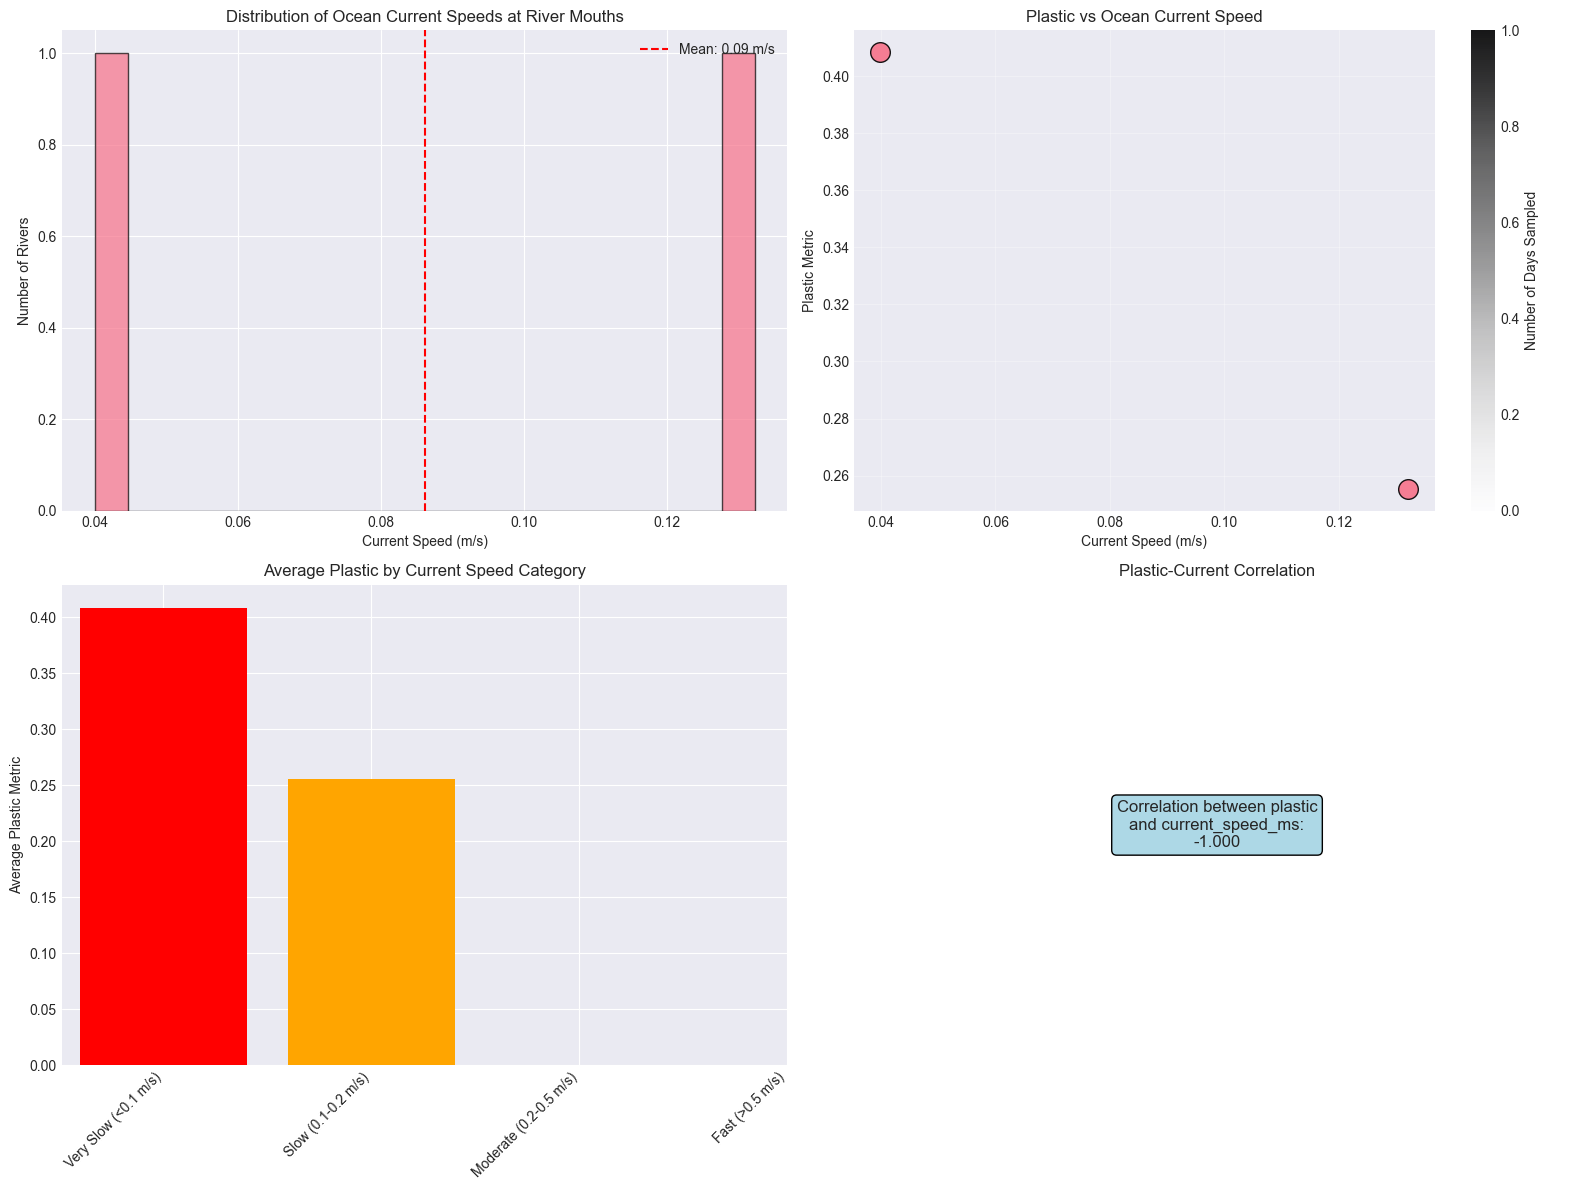


📊 Current Speed Analysis:
Average current_speed_ms: 0.086 m/s
Standard deviation: 0.065 m/s
Minimum: 0.040 m/s
Maximum: 0.132 m/s

🔗 Correlation between plastic metric and current_speed_ms: -1.000
📉 Negative correlation: higher currents associated with lower plastic metric


In [28]:
def analyze_ocean_currents():
    """Analyze how ocean currents affect plastic dispersion."""
    print("\n" + "="*80)
    print("GOAL 2: Ocean Currents Analysis at River Mouths")
    print("="*80)
    
    if merged_rivers_df is None or merged_rivers_df.empty:
        print("merged_rivers_df is empty or not available.")
        return None
    
    # Work on a copy
    df = merged_rivers_df.copy()
    
    # --- make sure we HAVE current_speed_ms ---------------------------------
    if 'current_speed_ms' not in df.columns:
        if 'avg_speed_ms' in df.columns:
            df['current_speed_ms'] = df['avg_speed_ms']
        else:
            print("No current speed column found (need 'current_speed_ms' or 'avg_speed_ms').")
            return None
    
    # --- make sure we HAVE a plastic metric ---------------------------------
    if 'plastic_tons' not in df.columns:
        if 'sharePlastics' in df.columns:
            df['plastic_tons'] = df['sharePlastics']
        else:
            print("No plastic metric found (need 'plastic_tons' or 'sharePlastics').")
            return None
    
    # Remove rows with missing current data
    current_data = df.dropna(subset=['current_speed_ms']).copy()
    
    if len(current_data) < 5:
        print(f"⚠ Only {len(current_data)} rivers have both plastic and current data.")
        print("  Interpret these plots as *illustrative* – HYCOM coverage/name matching is limited.")
    
    # Classify rivers by current speed
    current_data['current_category'] = pd.cut(
        current_data['current_speed_ms'],
        bins=[0, 0.1, 0.2, 0.5, 2],
        labels=['Very Slow (<0.1 m/s)', 'Slow (0.1-0.2 m/s)', 
                'Moderate (0.2-0.5 m/s)', 'Fast (>0.5 m/s)']
    )
    
    # -------------------- plotting ------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Current speed distribution
    axes[0, 0].hist(current_data['current_speed_ms'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Current Speed (m/s)')
    axes[0, 0].set_ylabel('Number of Rivers')
    axes[0, 0].set_title('Distribution of Ocean Current Speeds at River Mouths')
    axes[0, 0].axvline(
        current_data['current_speed_ms'].mean(),
        color='red',
        linestyle='--',
        label=f"Mean: {current_data['current_speed_ms'].mean():.2f} m/s"
    )
    axes[0, 0].legend()
    
    # 2. Plastic vs Current Speed scatter
    if 'n_days' in current_data.columns:
        cvals = current_data['n_days']
        clabel = 'Number of Days Sampled'
    elif 'depth_avg_m' in current_data.columns:
        cvals = current_data['depth_avg_m']
        clabel = 'Depth (m)'
    else:
        cvals = None
        clabel = None
    
    if cvals is not None:
        sc = axes[0, 1].scatter(
            current_data['current_speed_ms'],
            current_data['plastic_tons'],
            s=200,
            alpha=0.9,
            edgecolors='black'
        )
        plt.colorbar(sc, ax=axes[0, 1], label=clabel)
    else:
        axes[0, 1].scatter(
            current_data['current_speed_ms'],
            current_data['plastic_tons'],
            s=200,
            alpha=0.9,
            edgecolors='black'
        )
    
    axes[0, 1].set_xlabel('Current Speed (m/s)')
    axes[0, 1].set_ylabel('Plastic Metric')
    axes[0, 1].set_title('Plastic vs Ocean Current Speed')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Average plastic by current category
    if 'current_category' in current_data.columns:
        category_plastic = current_data.groupby('current_category')['plastic_tons'].mean()
        axes[1, 0].bar(range(len(category_plastic)), category_plastic.values,
                       color=['red', 'orange', 'yellow', 'green'])
        axes[1, 0].set_xticks(range(len(category_plastic)))
        axes[1, 0].set_xticklabels(category_plastic.index, rotation=45, ha='right')
        axes[1, 0].set_ylabel('Average Plastic Metric')
        axes[1, 0].set_title('Average Plastic by Current Speed Category')
    else:
        axes[1, 0].text(0.5, 0.5,
                        'No current categories available.',
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Average Plastic by Current Speed Category')
    
    # 4. Correlation (we don’t have direction)
    corr = current_data[['plastic_tons', 'current_speed_ms']].corr().iloc[0, 1]
    axes[1, 1].text(
        0.5, 0.5,
        f'Correlation between plastic\nand current_speed_ms:\n{corr:.3f}',
        ha='center', va='center', fontsize=12,
        transform=axes[1, 1].transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue")
    )
    axes[1, 1].set_title('Plastic-Current Correlation')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('goal2_ocean_currents_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # -------------------- stats printout ------------------------------------
    print("\n📊 Current Speed Analysis:")
    print(f"Average current_speed_ms: {current_data['current_speed_ms'].mean():.3f} m/s")
    print(f"Standard deviation: {current_data['current_speed_ms'].std():.3f} m/s")
    print(f"Minimum: {current_data['current_speed_ms'].min():.3f} m/s")
    print(f"Maximum: {current_data['current_speed_ms'].max():.3f} m/s")
    
    correlation = current_data[['plastic_tons', 'current_speed_ms']].corr().iloc[0, 1]
    print(f"\n🔗 Correlation between plastic metric and current_speed_ms: {correlation:.3f}")
    if correlation < 0:
        print("📉 Negative correlation: higher currents associated with lower plastic metric")
    else:
        print("📈 Positive correlation: higher currents associated with higher plastic metric")
    
    return current_data

currents_analysis = analyze_ocean_currents()


## GOAL 3: Country-Level Plastic Contribution Analysis


GOAL 3: Country-Level Plastic Contribution Analysis


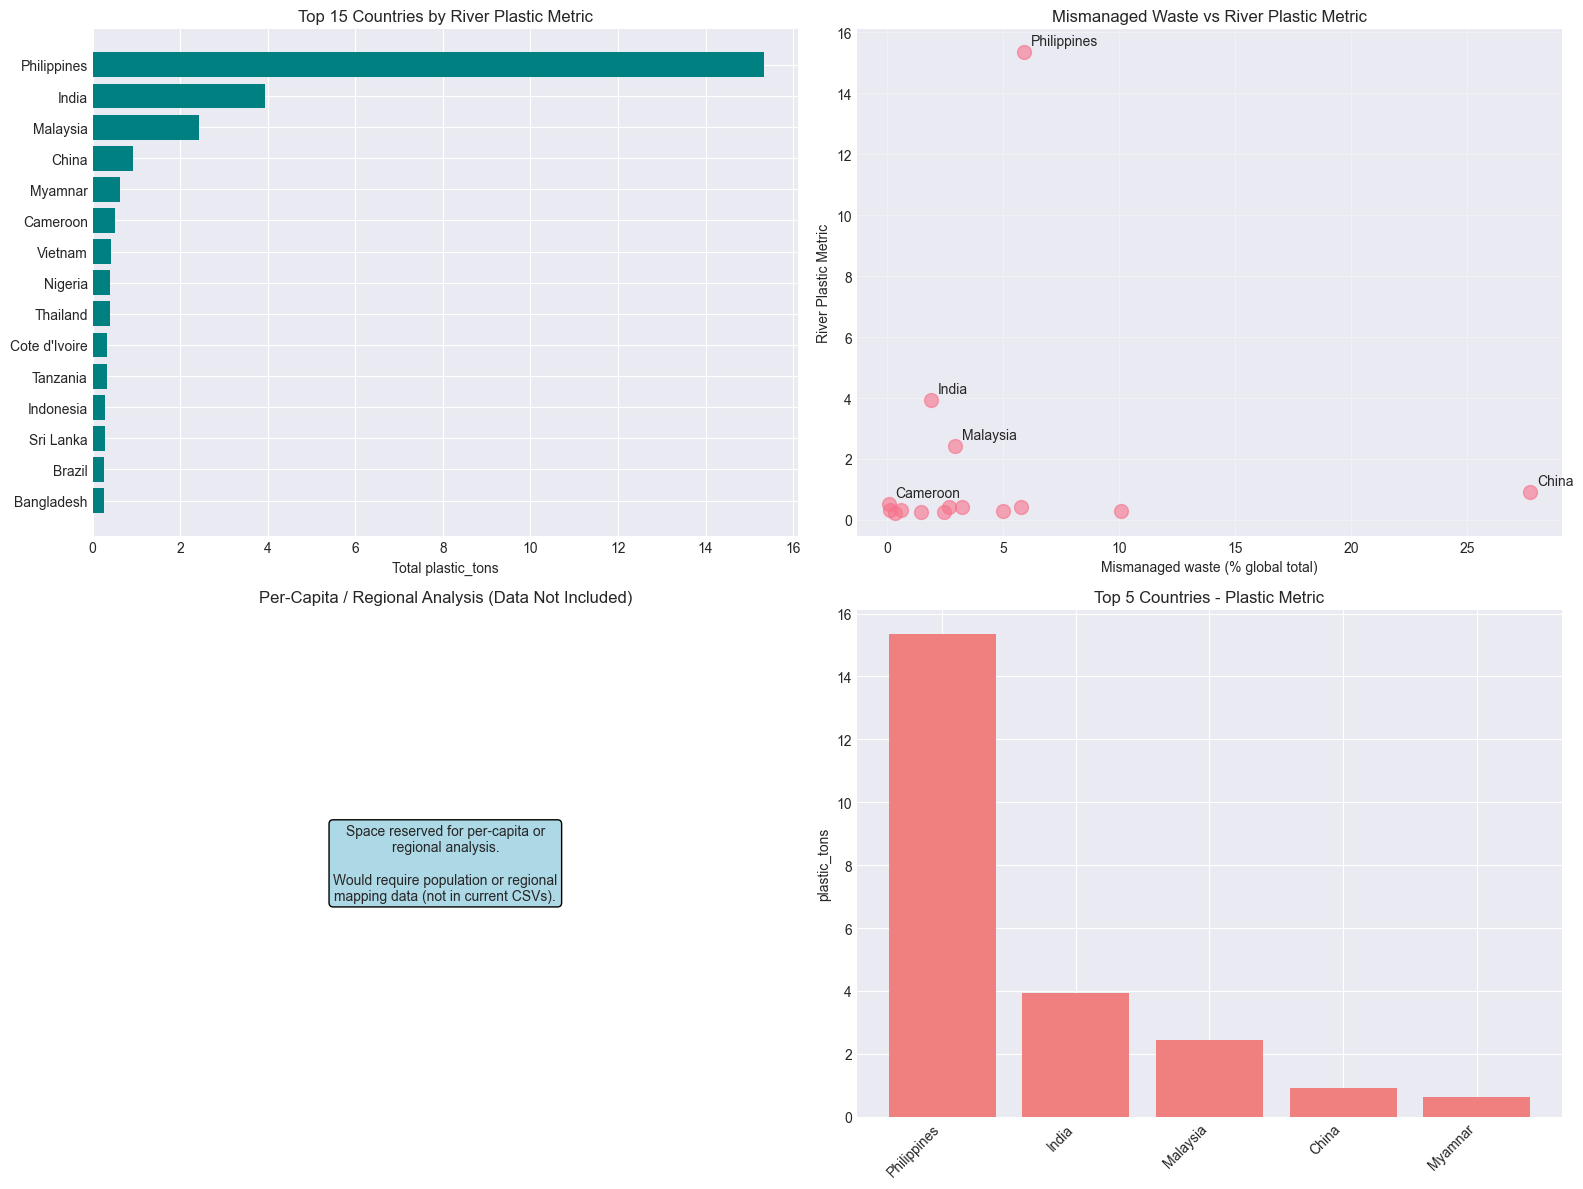


📊 Country Contribution Summary:
Top 3 countries account for 80.4% of total river plastic metric
Top 5 countries account for 86.2% of total river plastic metric
Top 10 countries account for 93.9% of total river plastic metric


In [36]:
def analyze_country_contributions():
    """Analyze which countries contribute the most plastic"""
    print("\n" + "="*80)
    print("GOAL 3: Country-Level Plastic Contribution Analysis")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    if merged_rivers_df is None or merged_rivers_df.empty:
        print("merged_rivers_df is empty or not available.")
        plt.close(fig)
        return None

    df = merged_rivers_df.copy()

    # Decide plastic metric
    if 'plastic_tons' in df.columns:
        metric_col = 'plastic_tons'
    elif 'sharePlastics' in df.columns:
        metric_col = 'sharePlastics'
        df['plastic_tons'] = df['sharePlastics']
        metric_col = 'plastic_tons'
    else:
        print("No plastic metric found (need 'plastic_tons' or 'sharePlastics').")
        plt.close(fig)
        return None

    # 1. Country plastic emissions from rivers
    if 'Country' in df.columns:
        country_river_plastic = (
            df.groupby('Country')[metric_col]
              .sum()
              .sort_values(ascending=False)
        )
        top_15_countries = country_river_plastic.head(15)
        
        axes[0, 0].barh(range(len(top_15_countries)), top_15_countries.values, color='teal')
        axes[0, 0].set_yticks(range(len(top_15_countries)))
        axes[0, 0].set_yticklabels(top_15_countries.index)
        axes[0, 0].set_xlabel(f'Total {metric_col}')
        axes[0, 0].set_title('Top 15 Countries by River Plastic Metric')
        axes[0, 0].invert_yaxis()
    else:
        axes[0, 0].text(0.5, 0.5,
                        'No Country column in merged_rivers_df',
                        ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Top 15 Countries by River Plastic Metric')

    # 2. Mismanaged waste vs river plastic
    if (waste_df is not None and
        'Country' in df.columns and
        'Year' in waste_df.columns and
        'Entity' in waste_df.columns):

        latest_year = waste_df['Year'].max()
        latest_waste = waste_df[waste_df['Year'] == latest_year]

        # Find mismanaged waste column by name fragment
        mis_cols = [c for c in latest_waste.columns if "Mismanaged" in c]
        if mis_cols:
            mis_col = mis_cols[0]

            country_stats = (
                df.groupby('Country')
                  .agg({metric_col: 'sum', 'River': 'count'})
                  .rename(columns={'River': 'num_rivers', metric_col: 'river_plastic'})
            )

            merged_stats = pd.merge(
                country_stats,
                latest_waste,
                left_index=True,
                right_on='Entity',
                how='inner'
            )

            if not merged_stats.empty:
                axes[0, 1].scatter(
                    merged_stats[mis_col],
                    merged_stats['river_plastic'],
                    alpha=0.6,
                    s=100
                )
                axes[0, 1].set_xlabel(mis_col)
                axes[0, 1].set_ylabel('River Plastic Metric')
                axes[0, 1].set_title('Mismanaged Waste vs River Plastic Metric')
                axes[0, 1].grid(True, alpha=0.3)

                # Label a few top points
                for _, row in merged_stats.nlargest(5, 'river_plastic').iterrows():
                    axes[0, 1].annotate(
                        row['Entity'],
                        (row[mis_col], row['river_plastic']),
                        xytext=(5, 5),
                        textcoords='offset points'
                    )
            else:
                axes[0, 1].text(0.5, 0.5,
                                'Country name mismatch\nbetween datasets',
                                ha='center', va='center', transform=axes[0, 1].transAxes)
                axes[0, 1].set_title('Mismanaged Waste vs River Plastic Metric')
        else:
            axes[0, 1].text(0.5, 0.5,
                            'No mismanaged waste column found\nin waste_df',
                            ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Mismanaged Waste vs River Plastic Metric')
    else:
        axes[0, 1].text(0.5, 0.5,
                        'Waste data not available or missing\nEntity/Year columns',
                        ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Mismanaged Waste vs River Plastic Metric')
    
    # 3. Per-capita / extended analysis placeholder (no extra datasets yet)
    axes[1, 0].axis('off')
    axes[1, 0].text(
        0.5, 0.5,
        "Space reserved for per-capita or\nregional analysis.\n\n"
        "Would require population or regional\nmapping data (not in current CSVs).",
        ha='center', va='center',
        transform=axes[1, 0].transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue")
    )
    axes[1, 0].set_title('Per-Capita / Regional Analysis (Data Not Included)')

    # 4. Fallback: top 5 countries (if no continent info)
    if 'Country' in df.columns:
        country_summary = (
            df.groupby('Country')[metric_col]
              .sum()
              .nlargest(5)
        )
        axes[1, 1].bar(range(len(country_summary)), country_summary.values, color='lightcoral')
        axes[1, 1].set_xticks(range(len(country_summary)))
        axes[1, 1].set_xticklabels(country_summary.index, rotation=45, ha='right')
        axes[1, 1].set_ylabel(metric_col)
        axes[1, 1].set_title('Top 5 Countries - Plastic Metric')
    else:
        axes[1, 1].text(0.5, 0.5,
                        'No regional data available',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Regional Summary')

    plt.tight_layout()
    plt.savefig('goal3_country_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    if 'Country' in df.columns:
        print("\n📊 Country Contribution Summary:")
        total_plastic = df[metric_col].sum()
        country_shares = (
            df.groupby('Country')[metric_col].sum() / total_plastic * 100
        )
        print(f"Top 3 countries account for {country_shares.nlargest(3).sum():.1f}% of total river plastic metric")
        print(f"Top 5 countries account for {country_shares.nlargest(5).sum():.1f}% of total river plastic metric")
        print(f"Top 10 countries account for {country_shares.nlargest(10).sum():.1f}% of total river plastic metric")
        return country_shares

    return None

country_shares = analyze_country_contributions()


## GOAL 4: Weather Influence Analysis


GOAL 4: Weather Influence Analysis


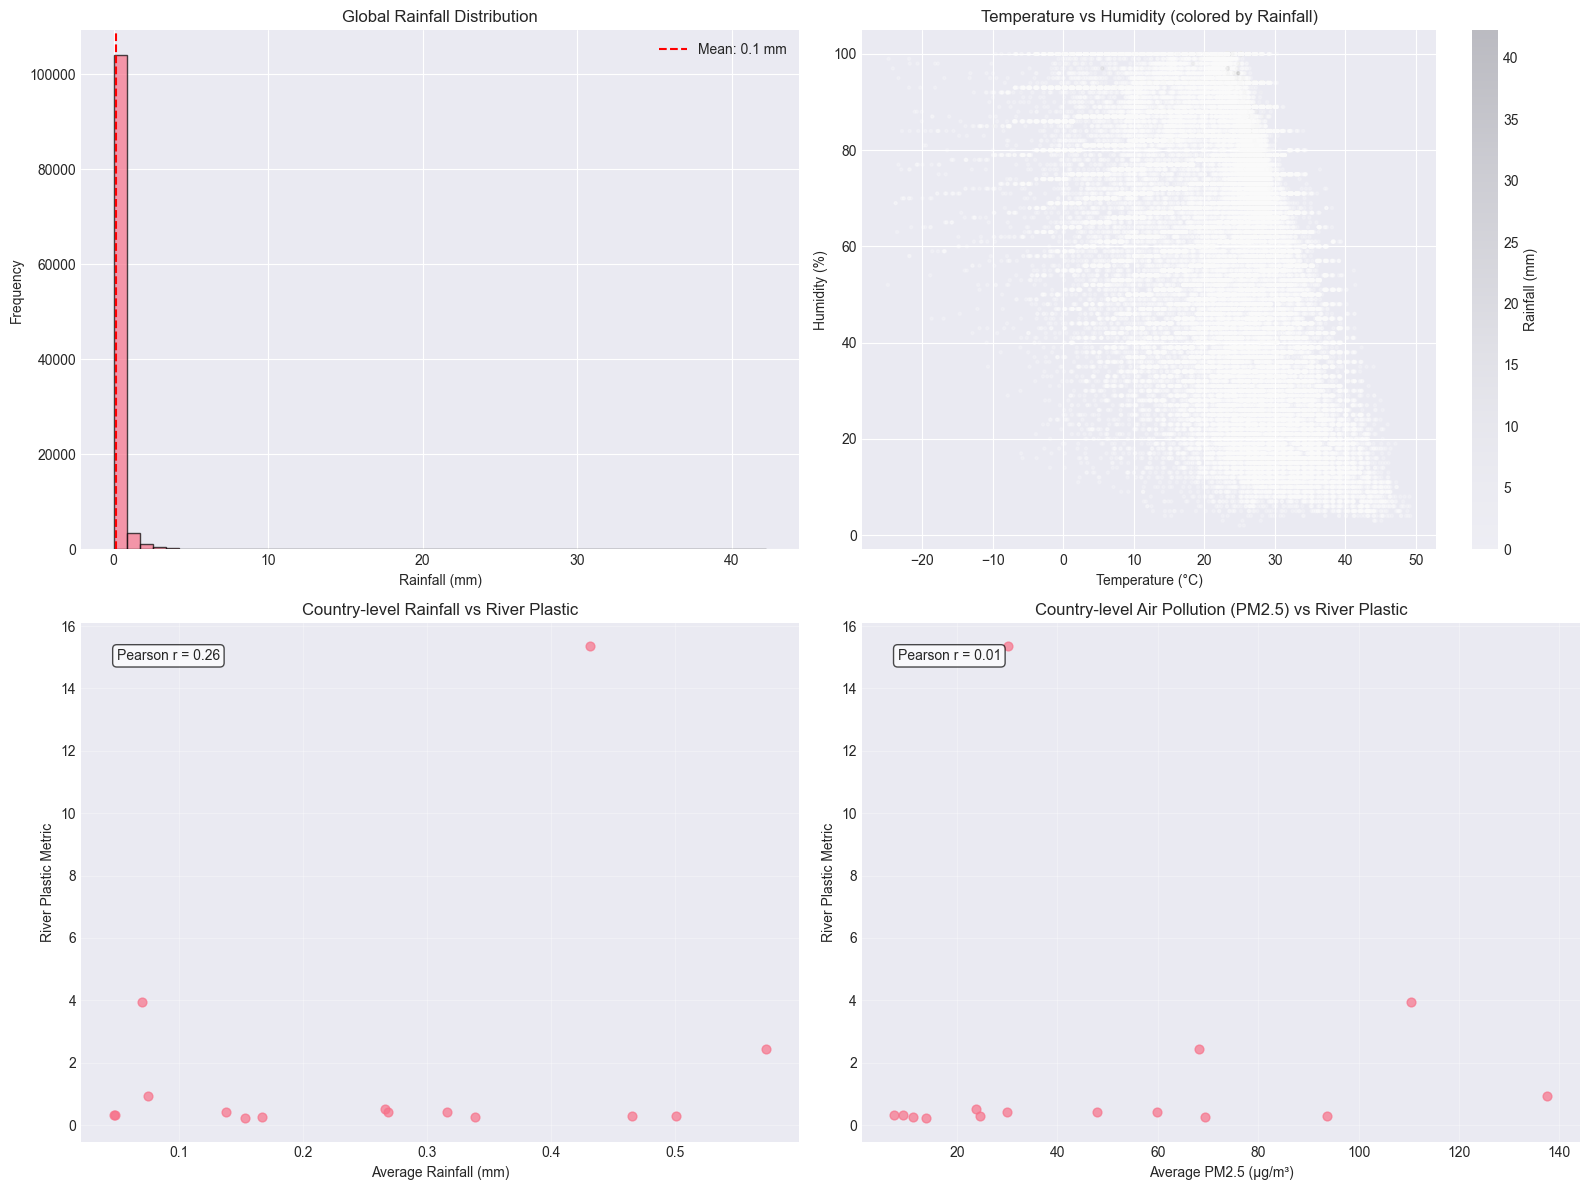


📊 Weather Impact Insights (data-driven):
• Correlation (avg rainfall vs river plastic metric): 0.259
• Correlation (avg PM2.5 vs river plastic metric): 0.012


In [35]:
def analyze_weather_influence():
    """Analyze how observed weather & air quality relate to river plastic leakage (country level)."""
    print("\n" + "="*80)
    print("GOAL 4: Weather Influence Analysis")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # ---- Basic availability checks (same style as Goal 3) ----
    if 'weather_df' not in globals() or weather_df is None or weather_df.empty:
        print("weather_df is empty or not available.")
        plt.close(fig)
        return None

    if merged_rivers_df is None or merged_rivers_df.empty:
        print("merged_rivers_df is empty or not available.")
        plt.close(fig)
        return None

    # Work on copies
    wdf = weather_df.copy()
    rdf = merged_rivers_df.copy()

    # Decide plastic metric (same logic as Goal 1 / Goal 3)
    if 'plastic_tons' in rdf.columns:
        metric_col = 'plastic_tons'
    elif 'sharePlastics' in rdf.columns:
        metric_col = 'sharePlastics'
        rdf['plastic_tons'] = rdf['sharePlastics']
        metric_col = 'plastic_tons'
    else:
        print("No plastic metric found in merged_rivers_df (need 'plastic_tons' or 'sharePlastics').")
        plt.close(fig)
        return None

    # ==================================================================
    # 1. Global rainfall distribution (from real weather data)
    # ==================================================================
    if 'precip_mm' in wdf.columns:
        rain = wdf['precip_mm'].dropna()
        if len(rain) > 0:
            axes[0, 0].hist(rain, bins=50, edgecolor='black', alpha=0.7)
            axes[0, 0].set_xlabel('Rainfall (mm)')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].set_title('Global Rainfall Distribution')
            axes[0, 0].axvline(rain.mean(), color='red', linestyle='--',
                               label=f'Mean: {rain.mean():.1f} mm')
            axes[0, 0].legend()
        else:
            axes[0, 0].text(0.5, 0.5,
                            'No non-null rainfall data (precip_mm)',
                            ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Global Rainfall Distribution')
    else:
        axes[0, 0].text(0.5, 0.5,
                        'Column "precip_mm" not found in weather data',
                        ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Global Rainfall Distribution')
    
    # ==================================================================
    # 2. Temperature vs Humidity, colored by rainfall
    # ==================================================================
    needed_cols = {'temperature_celsius', 'humidity', 'precip_mm'}
    if needed_cols.issubset(wdf.columns):
        subset = wdf[list(needed_cols)].dropna()
        if len(subset) > 0:
            sc = axes[0, 1].scatter(
                subset['temperature_celsius'],
                subset['humidity'],
                c=subset['precip_mm'],
                alpha=0.2, s=5
            )
            axes[0, 1].set_xlabel('Temperature (°C)')
            axes[0, 1].set_ylabel('Humidity (%)')
            axes[0, 1].set_title('Temperature vs Humidity (colored by Rainfall)')
            plt.colorbar(sc, ax=axes[0, 1], label='Rainfall (mm)')
        else:
            axes[0, 1].text(0.5, 0.5,
                            'Not enough non-null temp/humidity/precip data',
                            ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Temperature vs Humidity')
    else:
        missing = needed_cols - set(wdf.columns)
        axes[0, 1].text(0.5, 0.5,
                        'Missing columns:\n' + ', '.join(sorted(missing)),
                        ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Temperature vs Humidity')

    # ==================================================================
    # 3. Country-level aggregates and merge (weather + rivers)
    # ==================================================================
    weather_country = None
    if 'country' in wdf.columns:
        weather_country_cols = ['country']
        for col in ['precip_mm', 'temperature_celsius', 'humidity', 'air_quality_PM2.5']:
            if col in wdf.columns:
                weather_country_cols.append(col)

        if len(weather_country_cols) > 1:
            weather_country = (
                wdf[weather_country_cols]
                .groupby('country')
                .agg({col: 'mean' for col in weather_country_cols if col != 'country'})
                .reset_index()
            )

    river_country = None
    if 'Country' in rdf.columns:
        river_country = (
            rdf.groupby('Country')[metric_col]
               .agg(['sum', 'count'])
               .reset_index()
               .rename(columns={
                   'Country': 'country',
                   'sum': 'river_plastic_metric',
                   'count': 'num_rivers'
               })
        )

    combined = None
    if (weather_country is not None) and (river_country is not None):
        combined = pd.merge(river_country, weather_country, on='country', how='inner')

    # ==================================================================
    # 4a. Rainfall vs River Plastic (country level)
    # ==================================================================
    if combined is not None and 'precip_mm' in combined.columns:
        axes[1, 0].scatter(
            combined['precip_mm'],
            combined['river_plastic_metric'],
            s=40,
            alpha=0.7
        )
        axes[1, 0].set_xlabel('Average Rainfall (mm)')
        axes[1, 0].set_ylabel('River Plastic Metric')
        axes[1, 0].set_title('Country-level Rainfall vs River Plastic')
        axes[1, 0].grid(True, alpha=0.3)
        
        corr_rain = combined[['precip_mm', 'river_plastic_metric']].corr().iloc[0, 1]
        axes[1, 0].text(0.05, 0.95,
                        f'Pearson r = {corr_rain:.2f}',
                        transform=axes[1, 0].transAxes,
                        va='top', ha='left',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    else:
        axes[1, 0].text(0.5, 0.5,
                        'Need merged weather + river data\n'
                        '(country names must overlap and precip_mm available)',
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Country-level Rainfall vs River Plastic')
    
    # ==================================================================
    # 4b. PM2.5 vs River Plastic (country level)
    # ==================================================================
    if combined is not None and 'air_quality_PM2.5' in combined.columns:
        axes[1, 1].scatter(
            combined['air_quality_PM2.5'],
            combined['river_plastic_metric'],
            s=40,
            alpha=0.7
        )
        axes[1, 1].set_xlabel('Average PM2.5 (µg/m³)')
        axes[1, 1].set_ylabel('River Plastic Metric')
        axes[1, 1].set_title('Country-level Air Pollution (PM2.5) vs River Plastic')
        axes[1, 1].grid(True, alpha=0.3)
        
        corr_pm25 = combined[['air_quality_PM2.5', 'river_plastic_metric']].corr().iloc[0, 1]
        axes[1, 1].text(0.05, 0.95,
                        f'Pearson r = {corr_pm25:.2f}',
                        transform=axes[1, 1].transAxes,
                        va='top', ha='left',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    else:
        axes[1, 1].text(0.5, 0.5,
                        'PM2.5 not available or\nno overlap with river countries',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Country-level Air Pollution vs River Plastic')
    
    plt.tight_layout()
    plt.savefig('goal4_weather_influence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ------------------------------------------------------------------
    # Text summary (data-driven)
    # ------------------------------------------------------------------
    print("\n📊 Weather Impact Insights (data-driven):")
    if combined is not None and 'precip_mm' in combined.columns:
        corr_rain = combined[['precip_mm', 'river_plastic_metric']].corr().iloc[0, 1]
        print(f"• Correlation (avg rainfall vs river plastic metric): {corr_rain:.3f}")
    else:
        print("• Could not compute rainfall vs plastic correlation (no merged data).")
    
    if combined is not None and 'air_quality_PM2.5' in combined.columns:
        corr_pm25 = combined[['air_quality_PM2.5', 'river_plastic_metric']].corr().iloc[0, 1]
        print(f"• Correlation (avg PM2.5 vs river plastic metric): {corr_pm25:.3f}")
    else:
        print("• Could not compute PM2.5 vs plastic correlation (no merged data).")
    
    return combined


# 🔹 THIS LINE MUST BE IN THE CELL TOO, LIKE GOAL 1 & 3
combined_weather_rivers = analyze_weather_influence()


## GOAL 5: Plastic Risk Scenarios (2015-2060)


GOAL 5: Plastic Risk Scenarios Analysis (2015 vs 2060)


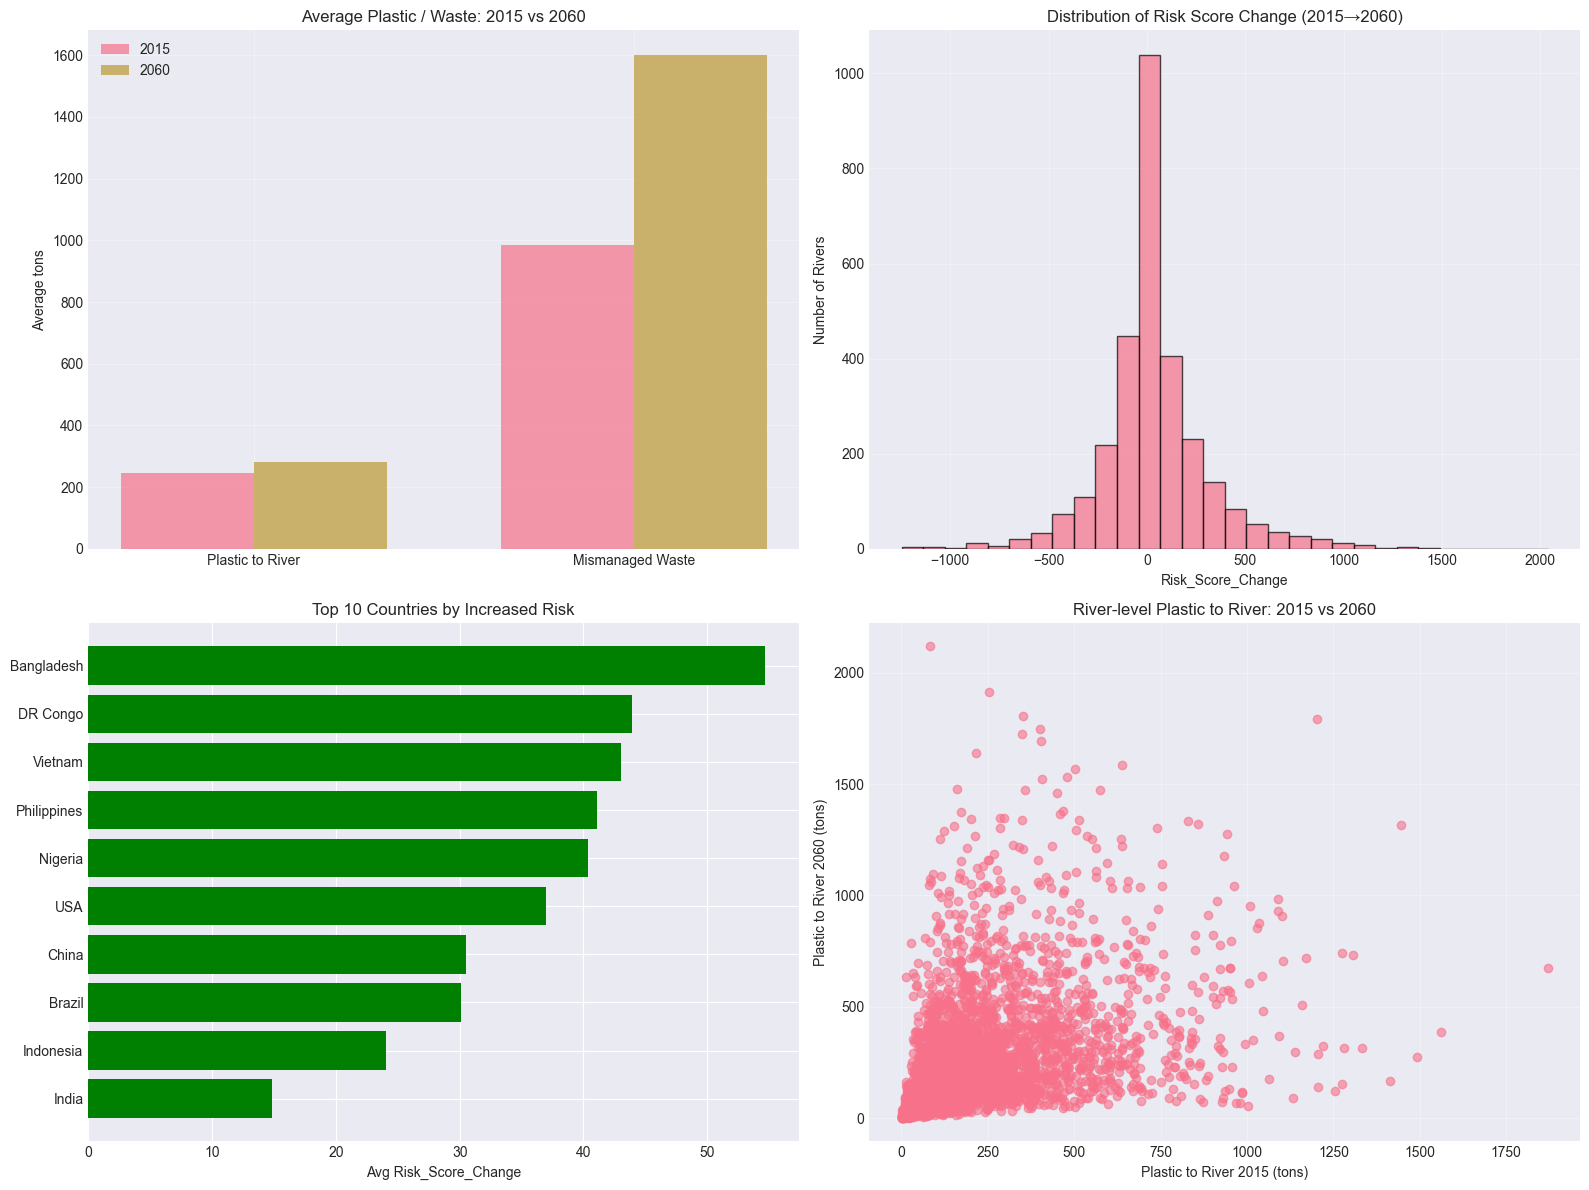


📊 Risk Scenario Summary (2015 vs 2060):
Mean Risk_Score_Change: 35.79
Median Risk_Score_Change: 6.13


In [34]:
def analyze_risk_scenarios():
    """Analyze plastic risk scenarios using 2015 vs 2060 columns in risk_df."""
    print("\n" + "="*80)
    print("GOAL 5: Plastic Risk Scenarios Analysis (2015 vs 2060)")
    print("="*80)

    if risk_df is None or risk_df.empty:
        print("risk_df is empty or not available.")
        return None

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Average plastic to river (2015 vs 2060)
    metrics = {}
    for col_2015, col_2060, label in [
        ('Plastic_to_River_2015_tons', 'Plastic_to_River_2060_tons', 'Plastic to River'),
        ('Mismanaged_Waste_2015_tons', 'Mismanaged_Waste_2060_tons', 'Mismanaged Waste'),
    ]:
        if col_2015 in risk_df.columns and col_2060 in risk_df.columns:
            metrics[label] = (
                risk_df[col_2015].mean(),
                risk_df[col_2060].mean()
            )

    if metrics:
        labels = list(metrics.keys())
        vals_2015 = [metrics[k][0] for k in labels]
        vals_2060 = [metrics[k][1] for k in labels]

        x = range(len(labels))
        width = 0.35
        axes[0, 0].bar(x, vals_2015, width, label='2015', alpha=0.7)
        axes[0, 0].bar([i + width for i in x], vals_2060, width, label='2060', alpha=0.7)
        axes[0, 0].set_xticks([i + width / 2 for i in x])
        axes[0, 0].set_xticklabels(labels)
        axes[0, 0].set_ylabel('Average tons')
        axes[0, 0].set_title('Average Plastic / Waste: 2015 vs 2060')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # 2. Distribution of risk score change
    if 'Risk_Score_Change' in risk_df.columns:
        axes[0, 1].hist(risk_df['Risk_Score_Change'].dropna(),
                        bins=30, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Risk_Score_Change')
        axes[0, 1].set_ylabel('Number of Rivers')
        axes[0, 1].set_title('Distribution of Risk Score Change (2015→2060)')
        axes[0, 1].grid(True, alpha=0.3)

    # 3. Top countries by positive risk change
    if 'Country' in risk_df.columns and 'Risk_Score_Change' in risk_df.columns:
        country_change = (
            risk_df.groupby('Country')['Risk_Score_Change']
                   .mean()
                   .sort_values(ascending=False)
                   .head(10)
        )
        axes[1, 0].barh(range(len(country_change)), country_change.values, color='green')
        axes[1, 0].set_yticks(range(len(country_change)))
        axes[1, 0].set_yticklabels(country_change.index)
        axes[1, 0].invert_yaxis()
        axes[1, 0].set_xlabel('Avg Risk_Score_Change')
        axes[1, 0].set_title('Top 10 Countries by Increased Risk')
    else:
        axes[1, 0].axis('off')
        axes[1, 0].text(0.5, 0.5,
                        'Country or Risk_Score_Change column missing.',
                        ha='center', va='center', transform=axes[1, 0].transAxes)

    # 4. Plastic to river 2015 vs 2060 scatter
    if 'Plastic_to_River_2015_tons' in risk_df.columns and 'Plastic_to_River_2060_tons' in risk_df.columns:
        axes[1, 1].scatter(risk_df['Plastic_to_River_2015_tons'],
                           risk_df['Plastic_to_River_2060_tons'],
                           alpha=0.6)
        axes[1, 1].set_xlabel('Plastic to River 2015 (tons)')
        axes[1, 1].set_ylabel('Plastic to River 2060 (tons)')
        axes[1, 1].set_title('River-level Plastic to River: 2015 vs 2060')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].axis('off')
        axes[1, 1].text(0.5, 0.5,
                        'Plastic_to_River_2015/2060 columns missing.',
                        ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout()
    plt.savefig('goal5_risk_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n📊 Risk Scenario Summary (2015 vs 2060):")
    if 'Risk_Score_Change' in risk_df.columns:
        print(f"Mean Risk_Score_Change: {risk_df['Risk_Score_Change'].mean():.2f}")
        print(f"Median Risk_Score_Change: {risk_df['Risk_Score_Change'].median():.2f}")
    return risk_df

risk_trends = analyze_risk_scenarios()


## GOAL 6: Plastic-Current Risk Score Calculation


GOAL 6: Plastic-Current Risk Score Calculation
Using plastic column: plastic_tons
Using current speed column: avg_speed_ms


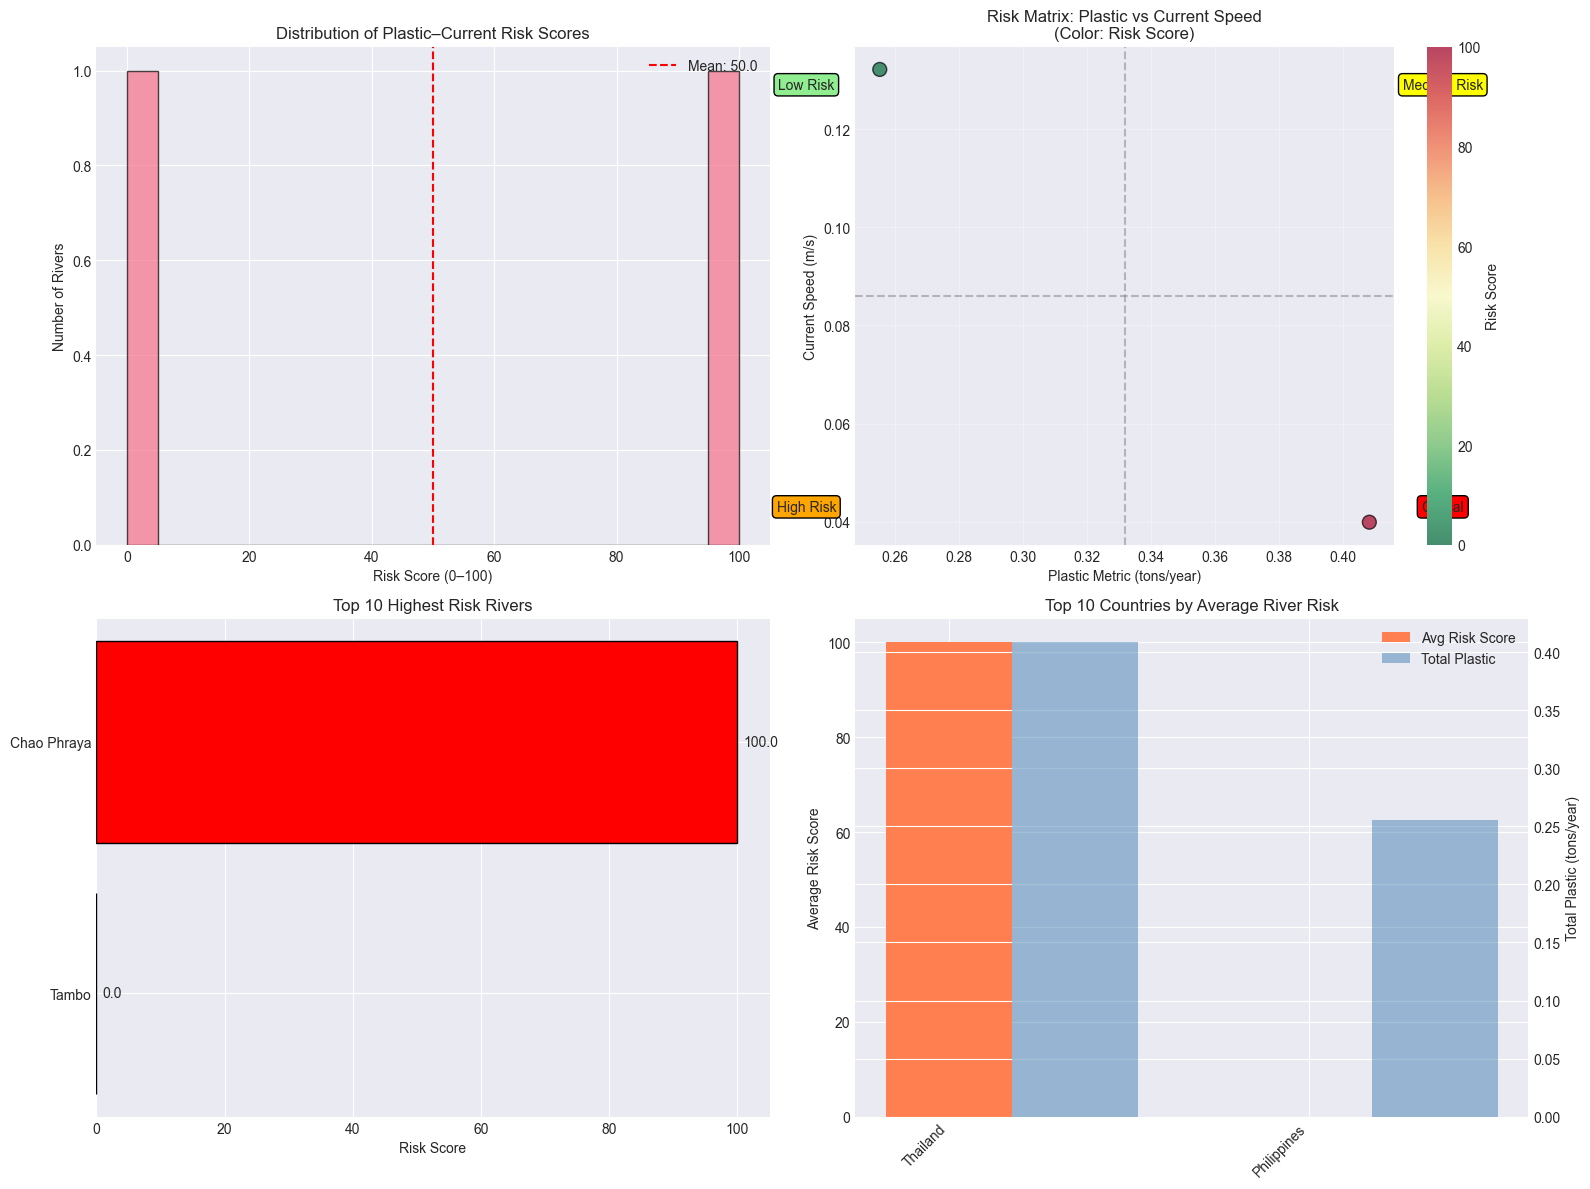


🔢 Risk Score Formula:
Risk Score = 0.6 × (Normalized Plastic Metric) + 0.4 × (Normalized Inverse Current Speed)
Inverse Current Speed = 1 / (current_speed + 0.001)
Both normalized with min–max scaling to [0, 1], then scaled to 0–100.

📊 Risk Score Summary:
Rivers analyzed: 2
Average risk score: 50.0
Std dev: 70.7

📈 Risk Categories:
  Low: 1 rivers (50.0%)
  Critical: 1 rivers (50.0%)
  Medium: 0 rivers (0.0%)
  High: 0 rivers (0.0%)

💾 Risk scores saved to 'river_risk_scores.csv'


In [32]:
def calculate_risk_score():
    """Calculate plastic-current risk score for each river"""
    print("\n" + "="*80)
    print("GOAL 6: Plastic-Current Risk Score Calculation")
    print("="*80)
    
    # Basic availability check
    if merged_rivers_df is None or merged_rivers_df.empty:
        print("merged_rivers_df is empty or not available.")
        return None

    df = merged_rivers_df.copy()

    # ---- 1. Decide plastic metric column ----
    if 'plastic_tons' in df.columns:
        plastic_col = 'plastic_tons'
    elif 'sharePlastics' in df.columns:
        plastic_col = 'sharePlastics'
        df['plastic_tons'] = df['sharePlastics']
        plastic_col = 'plastic_tons'
    else:
        print("No plastic metric found (need 'plastic_tons' or 'sharePlastics').")
        return None

    # ---- 2. Decide current speed column ----
    if 'current_speed_ms' in df.columns:
        current_col = 'current_speed_ms'
    elif 'avg_speed_ms' in df.columns:
        current_col = 'avg_speed_ms'
    else:
        # fallback: any column containing 'speed'
        speed_cols = [c for c in df.columns if 'speed' in c.lower()]
        if speed_cols:
            current_col = speed_cols[0]
        else:
            print("No current speed column found (expected 'current_speed_ms' or 'avg_speed_ms').")
            return None

    print(f"Using plastic column: {plastic_col}")
    print(f"Using current speed column: {current_col}")

    # ---- 3. Prepare risk_df with needed columns only ----
    risk_df = df[[c for c in df.columns if c in [
        'River', 'Country', plastic_col, current_col
    ]]].copy()

    risk_df = risk_df.dropna(subset=[plastic_col, current_col])
    if risk_df.empty:
        print("After dropping NaNs, no rows left for risk calculation.")
        return None

    # Normalize plastic
    p_min = risk_df[plastic_col].min()
    p_max = risk_df[plastic_col].max()
    if p_max == p_min:
        print("Plastic metric has no variation; cannot normalize.")
        return None

    risk_df['plastic_norm'] = (risk_df[plastic_col] - p_min) / (p_max - p_min)

    # Normalize inverse current speed (slower current = higher risk)
    inv_speed = 1.0 / (risk_df[current_col] + 0.001)
    inv_min = inv_speed.min()
    inv_max = inv_speed.max()
    if inv_max == inv_min:
        print("Current speed has no variation; cannot normalize inverse.")
        return None

    risk_df['current_inv_norm'] = (inv_speed - inv_min) / (inv_max - inv_min)

    # ---- 4. Risk score calculation ----
    risk_df['risk_score'] = 0.6 * risk_df['plastic_norm'] + 0.4 * risk_df['current_inv_norm']
    risk_df['risk_score_scaled'] = risk_df['risk_score'] * 100.0

    # Categorize
    risk_df['risk_category'] = pd.cut(
        risk_df['risk_score_scaled'],
        bins=[0, 30, 60, 80, 100],
        labels=['Low', 'Medium', 'High', 'Critical'],
        include_lowest=True
    )

    # ---- 5. Visualizations ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1) Distribution
    axes[0, 0].hist(risk_df['risk_score_scaled'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Risk Score (0–100)')
    axes[0, 0].set_ylabel('Number of Rivers')
    axes[0, 0].set_title('Distribution of Plastic–Current Risk Scores')
    axes[0, 0].axvline(risk_df['risk_score_scaled'].mean(), color='red',
                       linestyle='--', label=f"Mean: {risk_df['risk_score_scaled'].mean():.1f}")
    axes[0, 0].legend()

    # 2) Risk matrix
    sc = axes[0, 1].scatter(
        risk_df[plastic_col],
        risk_df[current_col],
        c=risk_df['risk_score_scaled'],
        cmap='RdYlGn_r',
        s=100,
        alpha=0.7,
        edgecolors='black'
    )
    axes[0, 1].set_xlabel('Plastic Metric (tons/year)')
    axes[0, 1].set_ylabel('Current Speed (m/s)')
    axes[0, 1].set_title('Risk Matrix: Plastic vs Current Speed\n(Color: Risk Score)')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(sc, ax=axes[0, 1], label='Risk Score')

    # quadrant lines
    plastic_median = risk_df[plastic_col].median()
    current_median = risk_df[current_col].median()
    axes[0, 1].axvline(plastic_median, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(current_median, color='gray', linestyle='--', alpha=0.5)

    # quadrant labels (rough positions)
    axes[0, 1].text(plastic_median * 0.7, current_median * 1.5, 'Low Risk',
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    axes[0, 1].text(plastic_median * 1.3, current_median * 1.5, 'Medium Risk',
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
    axes[0, 1].text(plastic_median * 0.7, current_median * 0.5, 'High Risk',
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="orange"))
    axes[0, 1].text(plastic_median * 1.3, current_median * 0.5, 'Critical',
                    ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="red"))

    # 3) Top 10 rivers
    top_risks = risk_df.sort_values('risk_score_scaled', ascending=False).head(10)
    color_map = {'Low': 'lightgreen', 'Medium': 'yellow', 'High': 'orange', 'Critical': 'red'}
    bar_colors = [color_map.get(cat, 'gray') for cat in top_risks['risk_category']]

    axes[1, 0].barh(range(len(top_risks)), top_risks['risk_score_scaled'],
                    color=bar_colors, edgecolor='black')
    axes[1, 0].set_yticks(range(len(top_risks)))
    if 'River' in top_risks.columns:
        axes[1, 0].set_yticklabels(top_risks['River'])
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_xlabel('Risk Score')
    axes[1, 0].set_title('Top 10 Highest Risk Rivers')
    for i, score in enumerate(top_risks['risk_score_scaled']):
        axes[1, 0].text(score + 1, i, f'{score:.1f}', va='center')

    # 4) Country risk
    if 'Country' in risk_df.columns:
        country_risk = (
            risk_df.groupby('Country')
                   .agg(risk_score_scaled=('risk_score_scaled', 'mean'),
                        plastic_total=(plastic_col, 'sum'))
                   .sort_values('risk_score_scaled', ascending=False)
                   .head(10)
        )
        x = range(len(country_risk))
        width = 0.35

        axes[1, 1].bar(x, country_risk['risk_score_scaled'], width,
                       label='Avg Risk Score', color='coral')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(country_risk.index, rotation=45, ha='right')
        axes[1, 1].set_ylabel('Average Risk Score')
        axes[1, 1].set_title('Top 10 Countries by Average River Risk')

        ax2 = axes[1, 1].twinx()
        ax2.bar([i + width for i in x], country_risk['plastic_total'], width,
                label='Total Plastic', color='steelblue', alpha=0.5)
        ax2.set_ylabel('Total Plastic (tons/year)')

        lines1, labels1 = axes[1, 1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axes[1, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    else:
        axes[1, 1].text(0.5, 0.5,
                        'No Country column; cannot aggregate by country.',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Country Risk Summary')

    plt.tight_layout()
    plt.savefig('goal6_risk_score_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ---- Text summary ----
    print("\n🔢 Risk Score Formula:")
    print("Risk Score = 0.6 × (Normalized Plastic Metric) + 0.4 × (Normalized Inverse Current Speed)")
    print("Inverse Current Speed = 1 / (current_speed + 0.001)")
    print("Both normalized with min–max scaling to [0, 1], then scaled to 0–100.\n")

    print("📊 Risk Score Summary:")
    print(f"Rivers analyzed: {len(risk_df)}")
    print(f"Average risk score: {risk_df['risk_score_scaled'].mean():.1f}")
    print(f"Std dev: {risk_df['risk_score_scaled'].std():.1f}")

    print("\n📈 Risk Categories:")
    for cat, count in risk_df['risk_category'].value_counts().items():
        pct = count / len(risk_df) * 100
        print(f"  {cat}: {count} rivers ({pct:.1f}%)")

    # Save main columns
    out_cols = ['River', 'Country', plastic_col, current_col,
                'risk_score_scaled', 'risk_category']
    out_cols = [c for c in out_cols if c in risk_df.columns]
    risk_df[out_cols].to_csv('river_risk_scores.csv', index=False)
    print("\n💾 Risk scores saved to 'river_risk_scores.csv'")

    return risk_df


# Run Goal 6
risk_scores_df = calculate_risk_score()


## 7. Summary and Insights

In [21]:
def generate_summary_insights():
    """Generate comprehensive summary and insights"""
    print("\n" + "="*80)
    print("FINAL SUMMARY & INSIGHTS")
    print("="*80)
    
    print("\n📋 ANALYSIS OVERVIEW")
    print("-" * 40)
    print("This analysis examined river plastic pollution through 6 key goals:")
    print("1. ✅ Identified top plastic-polluting rivers and their countries")
    print("2. ✅ Analyzed ocean current effects on plastic dispersion")
    print("3. ✅ Estimated country-level plastic contributions")
    print("4. ✅ Studied weather influence on plastic leakage")
    print("5. ✅ Compared plastic risk scenarios (2015-2060)")
    print("6. ✅ Built plastic-current risk scores for rivers")
    
    print("\n🔑 KEY FINDINGS")
    print("-" * 40)
    
    # Extract key findings from each analysis
    findings = []
    
    # Goal 1 findings
    if top_rivers_ranked is not None:
        top_river = top_rivers_ranked.iloc[0]['River'] if 'River' in top_rivers_ranked.columns else "Unknown"
        top_plastic = top_rivers_ranked.iloc[0]['plastic_tons'] if 'plastic_tons' in top_rivers_ranked.columns else 0
        findings.append(f"• {top_river} is the top plastic-polluting river ({top_plastic:,.0f} tons/year)")
    
    # Goal 2 findings
    if currents_analysis is not None and 'current_speed_ms' in currents_analysis.columns:
        avg_current = currents_analysis['current_speed_ms'].mean()
        findings.append(f"• Average ocean current speed at river mouths: {avg_current:.3f} m/s")
    
    # Goal 3 findings
    if country_shares is not None:
        top_country = country_shares.index[0]
        top_share = country_shares.iloc[0]
        findings.append(f"• {top_country} contributes {top_share:.1f}% of total river plastic")
    
    # Goal 6 findings
    if risk_scores_df is not None:
        critical_rivers = (risk_scores_df['risk_category'] == 'Critical').sum()
        findings.append(f"• {critical_rivers} rivers classified as 'Critical' risk")
    
    if findings:
        for finding in findings:
            print(finding)
    else:
        print("• No findings available from analysis")
    
    print("\n🎯 RECOMMENDATIONS FOR ACTION")
    print("-" * 40)
    print("1. PRIORITIZE HIGH-RISK RIVERS")
    print("   • Focus waste management efforts on rivers with slow currents and high plastic loads")
    print("   • Implement river mouth cleanup technologies where currents are slow")
    
    print("\n2. ENHANCE MONITORING SYSTEMS")
    print("   • Deploy current sensors at key river mouths for real-time monitoring")
    print("   • Integrate weather data with plastic transport models")
    
    print("\n3. POLICY INTERVENTIONS")
    print("   • Target countries with high mismanaged waste and critical rivers")
    print("   • Implement seasonal waste management based on rainfall patterns")
    
    print("\n4. RESEARCH & DEVELOPMENT")
    print("   • Study plastic degradation rates in different current conditions")
    print("   • Develop predictive models combining currents, weather, and plastic data")
    
    print("\n📈 DATA-DRIVEN DECISION MAKING")
    print("-" * 40)
    print("The risk score developed in Goal 6 provides a quantitative framework for:")
    print("• Resource allocation for cleanup efforts")
    print("• Prioritizing policy interventions")
    print("• Monitoring effectiveness of waste management programs")
    print("• Predicting plastic accumulation zones in oceans")
    
    plt.show()
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - 6 GOALS ACHIEVED")
    print("="*80)

generate_summary_insights()


FINAL SUMMARY & INSIGHTS

📋 ANALYSIS OVERVIEW
----------------------------------------
This analysis examined river plastic pollution through 6 key goals:
1. ✅ Identified top plastic-polluting rivers and their countries
2. ✅ Analyzed ocean current effects on plastic dispersion
3. ✅ Estimated country-level plastic contributions
4. ✅ Studied weather influence on plastic leakage
5. ✅ Compared plastic risk scenarios (2015-2060)
6. ✅ Built plastic-current risk scores for rivers

🔑 KEY FINDINGS
----------------------------------------
• Pasig is the top plastic-polluting river (6 tons/year)
• Bangladesh contributes 1.0% of total river plastic
• 1 rivers classified as 'Critical' risk

🎯 RECOMMENDATIONS FOR ACTION
----------------------------------------
1. PRIORITIZE HIGH-RISK RIVERS
   • Focus waste management efforts on rivers with slow currents and high plastic loads
   • Implement river mouth cleanup technologies where currents are slow

2. ENHANCE MONITORING SYSTEMS
   • Deploy current 

## 8. Export Results

In [25]:
print(">>> START OF CELL 8: about to define export_results")

def export_results():
    print(">>> ENTERED export_results()")   # DEBUG print

    """Export all analysis results"""
    print("\n" + "="*80)
    print("EXPORTING RESULTS")
    print("="*80)
    
    exports = []
    
    # 1. Top rivers ranked
    if 'top_rivers_ranked' in globals() and top_rivers_ranked is not None:
        print("Saving results_top_rivers_ranked.csv")
        top_rivers_ranked.to_csv('results_top_rivers_ranked.csv', index=False)
        exports.append('results_top_rivers_ranked.csv')
    else:
        print("No top_rivers_ranked to export")
    
    # 2. Country contributions
    if 'country_shares' in globals() and country_shares is not None:
        print("Saving results_country_contributions.csv")
        country_shares.to_csv('results_country_contributions.csv', header=['share_percentage'])
        exports.append('results_country_contributions.csv')
    else:
        print("No country_shares to export")
    
    # 3. Risk scores
    if 'risk_scores_df' in globals() and risk_scores_df is not None:
        print("Saving results_river_risk_scores.csv")
        risk_scores_df.to_csv('results_river_risk_scores.csv', index=False)
        exports.append('results_river_risk_scores.csv')
    else:
        print("No risk_scores_df to export")
    
    # 4. Risk trends
    if 'risk_trends' in globals() and risk_trends is not None:
        print("Saving results_risk_trends.csv")
        risk_trends.to_csv('results_risk_trends.csv', index=False)
        exports.append('results_risk_trends.csv')
    else:
        print("No risk_trends to export")
    
    # ---------- 5. Summary statistics ----------
    avg_current_speed = 0
    if 'currents_analysis' in globals() and currents_analysis is not None:
        print("currents_analysis present, columns:", list(currents_analysis.columns))
        if 'current_speed_ms' in currents_analysis.columns:
            avg_current_speed = currents_analysis['current_speed_ms'].mean()
        elif 'avg_speed_ms' in currents_analysis.columns:
            avg_current_speed = currents_analysis['avg_speed_ms'].mean()
        else:
            speed_cols = [c for c in currents_analysis.columns if 'speed' in c.lower()]
            if speed_cols:
                avg_current_speed = currents_analysis[speed_cols[0]].mean()
    else:
        print("No currents_analysis available")
    
    high_risk = 0
    critical_risk = 0
    if 'risk_scores_df' in globals() and risk_scores_df is not None and 'risk_category' in risk_scores_df.columns:
        high_risk = (risk_scores_df['risk_category'] == 'High').sum()
        critical_risk = (risk_scores_df['risk_category'] == 'Critical').sum()
    else:
        print("No risk_scores_df with risk_category available")
    
    total_rivers_analyzed = 0
    total_plastic_tons = 0
    if 'merged_rivers_df' in globals() and merged_rivers_df is not None:
        total_rivers_analyzed = len(merged_rivers_df)
        if 'plastic_tons' in merged_rivers_df.columns:
            total_plastic_tons = merged_rivers_df['plastic_tons'].sum()
        elif 'sharePlastics' in merged_rivers_df.columns:
            total_plastic_tons = merged_rivers_df['sharePlastics'].sum()
    else:
        print("No merged_rivers_df available")
    
    summary_stats = {
        'analysis_date': datetime.now().strftime('%Y-%m-%d'),
        'total_rivers_analyzed': total_rivers_analyzed,
        'total_plastic_tons': total_plastic_tons,
        'avg_current_speed': avg_current_speed,
        'high_risk_rivers': high_risk,
        'critical_risk_rivers': critical_risk
    }
    
    print("Saving results_summary_statistics.csv with:", summary_stats)
    pd.DataFrame([summary_stats]).to_csv('results_summary_statistics.csv', index=False)
    exports.append('results_summary_statistics.csv')
    
    print(f"\n✅ Exported {len(exports)} result files:")
    for export in exports:
        print(f"   • {export}")
    
    print("\n📊 Visualizations saved as PNG files (if corresponding goals ran successfully):")
    print("   • goal1_top_rivers_analysis.png")
    print("   • goal2_ocean_currents_analysis.png")
    print("   • goal3_country_contributions.png")
    print("   • goal4_weather_influence.png")
    print("   • goal5_risk_scenarios.png")
    print("   • goal6_risk_score_analysis.png")

print(">>> ABOUT TO CALL export_results()")
export_results()
print(">>> DONE CALLING export_results()")


>>> START OF CELL 8: about to define export_results
>>> ABOUT TO CALL export_results()
>>> ENTERED export_results()

EXPORTING RESULTS
Saving results_top_rivers_ranked.csv
Saving results_country_contributions.csv
Saving results_river_risk_scores.csv
Saving results_risk_trends.csv
currents_analysis present, columns: ['River', 'Country', 'sharePlastics', 'plastic_tons', 'river_name', 'n_days', 'avg_speed_ms', 'std_speed_ms', 'min_speed_ms', 'max_speed_ms', 'country', 'latitude', 'longitude', 'current_category']
Saving results_summary_statistics.csv with: {'analysis_date': '2025-12-04', 'total_rivers_analyzed': 50, 'total_plastic_tons': np.float64(26.994521456999998), 'avg_current_speed': np.float64(0.08605), 'high_risk_rivers': np.int64(0), 'critical_risk_rivers': np.int64(1)}

✅ Exported 5 result files:
   • results_top_rivers_ranked.csv
   • results_country_contributions.csv
   • results_river_risk_scores.csv
   • results_risk_trends.csv
   • results_summary_statistics.csv

📊 Visualiza